In [1]:
import json
import pandas as pd
import itertools
import csv
import pickle
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score


In [2]:
plt.style.use('seaborn')

In [3]:
pkl_path = '/Users/xzhou/github/project_files/yelp/yelp_lv_restaurant_reviews.pkl'

with open(pkl_path, 'rb') as pkl_file:
    df = pd.read_pickle(pkl_file)

In [4]:
df.shape

(676003, 15)

In [5]:
# Assign sentiment:

def assign_sentiment(x):
    sentiment = ''
    if x < 3:
        sentiment = -1
    elif x == 3:
        sentiment = 0
    else:
        sentiment =1
    return sentiment

In [6]:
df['sentiment'] = df['indi_customer_rating'].apply(lambda x: assign_sentiment(x))

In [7]:
df_sample = df.sample(15000, random_state=99)

In [8]:
X = df_sample['review']

In [9]:
y = df_sample['sentiment']

In [ ]:
# y.hist()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [10]:
tfidf_vector = TfidfVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=0.6,
                               min_df=0.01,
                               max_features=2000)
count_vector = CountVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=0.6,
                               min_df=0.01,
                               max_features=2000)

In [11]:
tfidf_data = tfidf_vector.fit_transform(X)

In [12]:
cv_data = count_vector.fit_transform(X)

In [30]:
tfidf_data.shape

(15000, 871)

In [13]:
tfidf_vector.get_feature_names()

['able',
 'absolutely',
 'actually',
 'add',
 'added',
 'ago',
 'amazing',
 'ambiance',
 'american',
 'appetizer',
 'appetizers',
 'area',
 'aren',
 'arrived',
 'asian',
 'ask',
 'asked',
 'asking',
 'ate',
 'atmosphere',
 'attention',
 'attentive',
 'authentic',
 'available',
 'average',
 'avocado',
 'away',
 'awesome',
 'ayce',
 'bacon',
 'bad',
 'baked',
 'banana',
 'bar',
 'barely',
 'bartender',
 'based',
 'basically',
 'bbq',
 'beans',
 'beat',
 'beautiful',
 'beef',
 'beer',
 'beers',
 'believe',
 'bellagio',
 'belly',
 'benedict',
 'best',
 'best ve',
 'better',
 'big',
 'bigger',
 'birthday',
 'bit',
 'bite',
 'bites',
 'black',
 'bland',
 'blue',
 'bomb',
 'bone',
 'bottle',
 'bowl',
 'boy',
 'boyfriend',
 'bread',
 'breakfast',
 'bring',
 'broth',
 'brought',
 'brown',
 'brunch',
 'bucks',
 'buffet',
 'buffets',
 'bun',
 'burger',
 'burgers',
 'burrito',
 'business',
 'busy',
 'butter',
 'buy',
 'cafe',
 'cake',
 'calamari',
 'california',
 'called',
 'came',
 'card',
 'care

In [14]:
# Dimension reduction
n_comp = 20
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

In [15]:
lsa_tfidf_data = lsa_tfidf.fit_transform(tfidf_data)
lsa_cv_data = lsa_cv.fit_transform(cv_data)
nmf_cv_data = lsa_cv.fit_transform(cv_data)

In [26]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path = '/Users/xzhou/github/project_files/yelp/review_vector_fit.pkl'

try:    
    with open(pkl_path, 'rb') as pkl_file:
        lsa_tfidf_data = pickle.load(pkl_file)
        lsa_cv_data = pickle.load(pkl_file)
        nmf_cv_data = pickle.load(pkl_file)
except:
    with open(pkl_path, 'wb') as pkl_file:
        pickle.dump(lsa_tfidf_data, pkl_file)
        pickle.dump(lsa_cv_data, pkl_file)
        pickle.dump(nmf_cv_data, pkl_file)

In [28]:
print(lsa_tfidf_data.shape, lsa_cv_data.shape, nmf_cv_data.shape)

(15000, 20) (15000, 20) (15000, 20)


In [17]:
lsa_tfidf_data

array([[ 0.17145928,  0.04062295,  0.01071573, ...,  0.00502629,
        -0.0655817 , -0.01947592],
       [ 0.10123688,  0.0336325 ,  0.02006741, ...,  0.05665297,
         0.01173755, -0.08540178],
       [ 0.21089724, -0.02839679, -0.03248867, ...,  0.11699005,
         0.12375645, -0.01170487],
       ...,
       [ 0.18700001, -0.04430118,  0.01604826, ...,  0.10401952,
         0.01965231,  0.04952527],
       [ 0.28634394,  0.07104724, -0.04181065, ...,  0.0006998 ,
        -0.0655722 , -0.0356567 ],
       [ 0.34590917, -0.05546795, -0.03153539, ...,  0.08640543,
         0.03712887,  0.01819989]])

In [18]:
SSEs = []
Sil_coefs = []

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=99, verbose=1, n_jobs=-1)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

Initialization complete
Initialization complete
start iteration
start iteration
done sorting
Initialization complete
done sorting
end inner loop
end inner loop
start iteration
done sorting
Iteration 0, inertia 1615.1663963064843
Iteration 0, inertia 1621.9635386611217
start iteration
start iteration
end inner loop
Initialization complete
done sorting
start iteration
done sorting
end inner loop
end inner loop
done sorting
Iteration 0, inertia 1604.8098647247693
start iteration
Iteration 1, inertia 1616.6216041668004
done sorting
Iteration 0, inertia 1621.6777667549893
end inner loop
start iteration
start iteration
done sorting
done sorting
Iteration 1, inertia 1587.0509211243009
start iteration
end inner loop
done sorting
end inner loop
end inner loop
end inner loop
Iteration 2, inertia 1581.1587283406152
start iteration
done sorting
Iteration 1, inertia 1600.3803460241882
start iteration
end inner loop
done sorting
Iteration 2, inertia 1613.44433962235
start iteration
Iteration 3, iner

end inner loop
end inner loop
Iteration 1, inertia 1592.704902502353
Iteration 21, inertia 1574.3411159253808
start iteration
done sorting
end inner loop
start iteration
done sorting
end inner loop
Iteration 2, inertia 1577.9443839635226
start iteration
done sorting
Iteration 22, inertia 1574.2777936328037
end inner loop
start iteration
done sorting
end inner loop
Iteration 3, inertia 1574.6865005839816
start iteration
done sorting
Iteration 23, inertia 1574.2015987488678
end inner loop
start iteration
done sorting
end inner loop
Iteration 4, inertia 1574.1077240762086
start iteration
done sorting
end inner loop
Iteration 24, inertia 1574.1219859583034
start iteration
done sorting
Iteration 5, inertia 1574.0031282601324
end inner loop
start iteration
done sorting
end inner loop
Iteration 25, inertia 1574.0689700349467
Iteration 26, inertia 1574.1831226494708
start iteration
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 27, inertia 157

start iteration
Iteration 9, inertia 1575.0396481708815
done sorting
start iteration
start iteration
end inner loop
done sorting
end inner loop
done sorting
end inner loop
Iteration 10, inertia 1574.8495335166986
start iteration
Iteration 10, inertia 1575.1286236763071
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 11, inertia 1574.9378038919488
Iteration 11, inertia 1574.7008486956013
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 12, inertia 1574.8038342840007
Iteration 12, inertia 1574.6136558158173
start iteration
start iteration
done sorting
done sorting
Iteration 11, inertia 1575.3743981542818
end inner loop
end inner loop
start iteration
Iteration 13, inertia 1574.5453171988884
Iteration 16, inertia 1574.4130469032712
done sorting
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 12, inertia 1575.027111380767
Iteration 14, inertia 1

start iteration
Iteration 35, inertia 1573.691918770497
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 7, inertia 1573.7683002616275
start iteration
Iteration 36, inertia 1573.6890024055185
done sorting
center shift 7.027368e-04 within tolerance 5.561444e-07
end inner loop
Iteration 8, inertia 1573.7586062328191
start iteration
done sorting
end inner loop
Iteration 9, inertia 1573.7525624327443
start iteration
done sorting
end inner loop
Iteration 10, inertia 1573.7495939271798
start iteration
done sorting
end inner loop
Iteration 11, inertia 1573.7448829095342
start iteration
done sorting
end inner loop
Iteration 12, inertia 1573.7423718770617
center shift 5.186508e-04 within tolerance 5.561444e-07
Initialization complete
Initialization complete
Initialization complete
start iteration
done sorting
end inner loop
Initialization complete
start iteration
Iteration 0, inertia 1556.0105097262897
start iteration
done sorting
end inner loop
start iteration


done sorting
done sorting
end inner loop
Iteration 20, inertia 1513.5572735027488
end inner loop
start iteration
done sorting
end inner loop
Iteration 22, inertia 1497.7549827314529
start iteration
done sorting
Iteration 21, inertia 1513.4966302469022
end inner loop
start iteration
done sorting
Iteration 23, inertia 1497.6712017382306
end inner loop
start iteration
done sorting
Iteration 22, inertia 1513.4332280773451
start iteration
end inner loop
done sorting
end inner loop
Iteration 24, inertia 1497.5550169099838
start iteration
done sorting
Iteration 0, inertia 1576.680718646693
Iteration 23, inertia 1513.3709151681178
end inner loop
start iteration
done sorting
Iteration 25, inertia 1497.4120326166346
end inner loop
start iteration
start iteration
done sorting
end inner loop
Iteration 24, inertia 1513.2981227954185
done sorting
start iteration
done sorting
end inner loop
Iteration 26, inertia 1497.2811066339289
start iteration
done sorting
end inner loop
Iteration 25, inertia 1513

Iteration 45, inertia 1511.4340926697248
start iteration
done sorting
end inner loop
Iteration 46, inertia 1511.1691649971283
start iteration
done sorting
end inner loop
Iteration 23, inertia 1508.3755787458788
start iteration
Iteration 47, inertia 1510.8289292772038
start iteration
Initialization complete
done sorting
end inner loop
start iteration
done sorting
done sorting
end inner loop
Iteration 48, inertia 1510.300422664595
start iteration
done sorting
end inner loop
Iteration 0, inertia 1568.482327806512
start iteration
done sorting
Iteration 49, inertia 1509.7754705449197
start iteration
end inner loop
done sorting
Iteration 49, inertia 1508.870870126872
end inner loop
Iteration 1, inertia 1551.613423317873
start iteration
done sorting
Iteration 50, inertia 1509.4870679221563
start iteration
end inner loop
done sorting
end inner loop
Iteration 2, inertia 1543.3283348010593
start iteration
Iteration 51, inertia 1509.323480621795
done sorting
start iteration
done sorting
end inner

Iteration 0, inertia 1574.580020476952
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 25, inertia 1516.5502090334244
start iteration
done sorting
Iteration 1, inertia 1556.8287387188836
start iteration
end inner loop
done sorting
end inner loop
Iteration 16, inertia 1511.7143122417415
Iteration 26, inertia 1516.4400687564296
start iteration
done sorting
start iteration
end inner loop
Iteration 2, inertia 1546.215912079478
done sorting
start iteration
Iteration 27, inertia 1516.3531852206777
end inner loop
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 17, inertia 1511.5739094383894
Iteration 3, inertia 1538.5434593260418
start iteration
done sorting
Iteration 28, inertia 1516.2440475361514
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteration 15, inertia 1499.176647857785
start iteration
Iteration 29, inertia 1516.1269047827263
Iteration 4, in

Iteration 43, inertia 1509.8438229739656
start iteration
done sorting
done sorting
Iteration 37, inertia 1496.7689015030649
end inner loop
start iteration
end inner loop
done sorting
done sorting
end inner loop
Iteration 44, inertia 1509.8378271593972
start iteration
end inner loop
Iteration 2, inertia 1536.3508106296626
done sorting
Iteration 38, inertia 1496.7613949523309
end inner loop
start iteration
start iteration
done sorting
end inner loop
done sorting
Iteration 45, inertia 1509.8325732082053
end inner loop
start iteration
done sorting
Iteration 39, inertia 1496.7569650855114
end inner loop
start iteration
done sorting
Iteration 3, inertia 1527.944353865161
Iteration 25, inertia 1515.3379422166222
end inner loop
Iteration 46, inertia 1509.8248764743907
start iteration
start iteration
done sorting
done sorting
Iteration 40, inertia 1496.7519912627754
end inner loop
start iteration
end inner loop
start iteration
done sorting
end inner loop
Iteration 4, inertia 1522.6545993869026


Iteration 54, inertia 1514.2768509253617
Iteration 71, inertia 1509.5865001318423
start iteration
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 31, inertia 1508.5920341420272
start iteration
Iteration 72, inertia 1509.553903909927
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 55, inertia 1514.2563790489996
start iteration
done sorting
end inner loop
Iteration 32, inertia 1508.4729639529605
start iteration
Iteration 56, inertia 1514.2439081189414
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 73, inertia 1509.4931601632932
Iteration 57, inertia 1514.2301752437352
start iteration
start iteration
done sorting
done sorting
end inner loop
Iteration 33, inertia 1508.4055319836343
end inner loop
start iteration
done sorting
Iteration 58, inertia 1514.2132488055138
end inner loop
start iteration
Iteration 74, inertia 1509.4347435102243
done sorting
Iteration 34, inertia 1508.3493048926816

done sorting
end inner loop
Iteration 3, inertia 1498.0417808025636
Iteration 3, inertia 1442.6192477109282
done sorting
end inner loop
end inner loop
Iteration 3, inertia 1466.5106065692244
Iteration 2, inertia 1454.283986236061
start iteration
start iteration
done sorting
done sorting
end inner loop
Iteration 3, inertia 1440.294315848827
start iteration
end inner loop
start iteration
done sorting
end inner loop
Iteration 4, inertia 1463.645452189247
Iteration 4, inertia 1431.8924297984972
start iteration
start iteration
done sorting
end inner loop
done sorting
end inner loop
Iteration 5, inertia 1429.2232700173565
start iteration
done sorting
end inner loop
Iteration 6, inertia 1428.212282831411
start iteration
Iteration 5, inertia 1461.341773040857
done sorting
done sorting
start iteration
done sorting
end inner loop
start iteration
end inner loop
done sorting
Iteration 4, inertia 1439.9707547351804
start iteration
Iteration 4, inertia 1491.885904785904
start iteration
done sorting


end inner loop
start iteration
done sorting
Iteration 26, inertia 1424.0772062177004
end inner loop
start iteration
done sorting
end inner loop
Initialization complete
Iteration 27, inertia 1438.2942981306915
start iteration
done sorting
Iteration 27, inertia 1424.0200722220538
end inner loop
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 28, inertia 1438.0969015737612
start iteration
done sorting
Iteration 28, inertia 1423.9796861255822
Iteration 0, inertia 1542.4444678758466
end inner loop
start iteration
done sorting
start iteration
done sorting
end inner loop
Iteration 29, inertia 1437.8747548571168
end inner loop
start iteration
Iteration 29, inertia 1423.9513108744786
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 1, inertia 1520.4262668532394
start iteration
Iteration 30, inertia 1437.6979783690072
start iteration
done sorting
Iteration 30, inertia 1423.9186684776346
done sorting
end inner loop

start iteration
done sorting
Iteration 50, inertia 1433.206702363438
end inner loop
start iteration
done sorting
Iteration 51, inertia 1420.6525771159702
end inner loop
start iteration
Iteration 24, inertia 1456.0002926029863
start iteration
done sorting
Iteration 51, inertia 1433.2036022138875
done sorting
center shift 6.740091e-04 within tolerance 5.561444e-07
end inner loop
end inner loop
Iteration 52, inertia 1420.1234584456229
Iteration 25, inertia 1455.9991108680113
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 53, inertia 1419.8281015644186
Iteration 26, inertia 1455.9989236088547
center shift 1.741914e-04 within tolerance 5.561444e-07
start iteration
done sorting
end inner loop
Iteration 54, inertia 1419.6177697284477
start iteration
done sorting
end inner loop
end inner loop
Iteration 55, inertia 1419.4529382618407
Initialization complete
Iteration 53, inertia 1434.5294353848806
start iteration
done sorting
end inner loop
sta

start iteration
done sorting
end inner loop
Iteration 22, inertia 1457.400520730717
start iteration
Iteration 11, inertia 1458.688701192152
done sorting
start iteration
done sorting
end inner loop
Iteration 20, inertia 1434.3824906119328
end inner loop
start iteration
Iteration 23, inertia 1457.1742993434273
done sorting
Iteration 12, inertia 1458.1332918248722
start iteration
start iteration
done sorting
end inner loop
done sorting
end inner loop
end inner loop
Iteration 21, inertia 1434.3501657727993
Iteration 24, inertia 1456.8988424583383
Iteration 13, inertia 1457.7432268911518
start iteration
start iteration
start iteration
done sorting
done sorting
done sorting
start iteration
end inner loop
end inner loop
end inner loop
Iteration 25, inertia 1456.6121714885699
Iteration 14, inertia 1457.319341712393
start iteration
start iteration
Iteration 22, inertia 1434.3363726010332
done sorting
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteratio

start iteration
end inner loop
Iteration 38, inertia 1433.1507067108232
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 36, inertia 1455.2958324733295
done sorting
start iteration
Iteration 39, inertia 1433.1302550173964
done sorting
end inner loop
start iteration
end inner loop
done sorting
Iteration 49, inertia 1454.7076601289702
end inner loop
Iteration 13, inertia 1453.1444008719443
Iteration 37, inertia 1455.0482814594086
start iteration
done sorting
start iteration
end inner loop
done sorting
Iteration 14, inertia 1452.9292010455267
end inner loop
start iteration
done sorting
end inner loop
Iteration 38, inertia 1454.748816839886
start iteration
done sorting
Iteration 15, inertia 1452.7683310590787
end inner loop
start iteration
done sorting
end inner loop
center shift 6.154686e-04 within tolerance 5.561444e-07
Iteration 39, inertia 1454.4857570255294
start iteration
done sorting
end inner loop
Iteration 40, inertia 1433.104253711

Iteration 7, inertia 1408.4206137742142
start iteration
done sorting
end inner loop
Iteration 8, inertia 1405.1866697116698
start iteration
done sorting
end inner loop
Iteration 9, inertia 1403.0702881678858
start iteration
done sorting
end inner loop
Iteration 10, inertia 1401.6164514969814
start iteration
Iteration 6, inertia 1406.4995319327388
start iteration
Iteration 7, inertia 1385.1927541252203
done sorting
start iteration
end inner loop
done sorting
Iteration 7, inertia 1396.6140416720823
end inner loop
Iteration 7, inertia 1371.901796558111
start iteration
start iteration
done sorting
done sorting
Iteration 8, inertia 1384.408065714927
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteration 8, inertia 1371.1384231970223
Iteration 9, inertia 1383.7386712513264
start iteration
start iteration
done sorting
done sorting
end inner loop
Iteration 8, inertia 1382.5341019020582
start iteration
end inner loop
Iteration 10, inertia 1383.1780650811156
done sor

start iteration
end inner loop
done sorting
end inner loop
Iteration 34, inertia 1387.5803055868892
start iteration
end inner loop
Iteration 27, inertia 1345.7717397338138
Iteration 30, inertia 1381.1548849474361
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 31, inertia 1381.1535765056353
Iteration 28, inertia 1345.7612671785446
center shift 6.806483e-04 within tolerance 5.561444e-07
start iteration
done sorting
end inner loop
Iteration 29, inertia 1345.7497668134038
start iteration
done sorting
end inner loop
done sorting
Iteration 30, inertia 1345.736959734438
start iteration
done sorting
end inner loop
end inner loop
Iteration 31, inertia 1345.7288592052828
start iteration
done sorting
end inner loop
Iteration 32, inertia 1345.7249011090048
start iteration
done sorting
end inner loop
Iteration 35, inertia 1384.3715732580558
Initialization complete
Iteration 33, inertia 1345.7225199238828
start iteration
start iteration
done sorting

start iteration
done sorting
Iteration 23, inertia 1382.1041971740926
Iteration 15, inertia 1381.000381076281
end inner loop
start iteration
start iteration
done sorting
end inner loop
done sorting
Iteration 19, inertia 1399.844734509917
start iteration
done sorting
end inner loop
end inner loop
Iteration 24, inertia 1382.0967288110623
start iteration
done sorting
Iteration 20, inertia 1399.51515671559
start iteration
end inner loop
done sorting
end inner loop
Iteration 25, inertia 1382.0937740064894
Iteration 16, inertia 1376.7416472781756
start iteration
start iteration
Iteration 21, inertia 1399.2867698098705
done sorting
start iteration
done sorting
end inner loop
done sorting
end inner loop
Iteration 26, inertia 1382.091196447352
Iteration 22, inertia 1399.0775321096035
start iteration
end inner loop
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 9, inertia 1396.404734377094
Iteration 17, inertia 1371.767432603473
start iteration
done sorting
end

done sorting
end inner loop
Iteration 18, inertia 1396.4183152115247
Iteration 35, inertia 1394.29703029084
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 38, inertia 1345.8297506518516
start iteration
end inner loop
Iteration 19, inertia 1396.2951608322242
done sorting
Iteration 42, inertia 1397.073266149831
start iteration
end inner loop
done sorting
end inner loop
Iteration 39, inertia 1345.7299922722966
Iteration 43, inertia 1397.071504005545
start iteration
start iteration
done sorting
end inner loop
done sorting
end inner loop
Iteration 44, inertia 1397.0701243740623
center shift 6.620657e-04 within tolerance 5.561444e-07
Iteration 40, inertia 1345.6724773742483
start iteration
done sorting
start iteration
end inner loop
Iteration 36, inertia 1394.2770093619783
done sorting
Iteration 41, inertia 1345.6231921986187
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 42, inertia 1345.59

done sorting
start iteration
end inner loop
done sorting
Iteration 4, inertia 1315.752792635673
start iteration
end inner loop
Iteration 2, inertia 1361.4722638231638
done sorting
start iteration
end inner loop
done sorting
Iteration 2, inertia 1355.4001395960406
end inner loop
Iteration 5, inertia 1314.17156585081
start iteration
start iteration
Iteration 5, inertia 1329.021117711206
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 6, inertia 1326.935703875157
start iteration
done sorting
end inner loop
Iteration 3, inertia 1344.3101594071682
Iteration 7, inertia 1325.9341379762002
start iteration
done sorting
start iteration
Iteration 3, inertia 1349.392499869739
end inner loop
done sorting
Iteration 8, inertia 1325.1986163032
start iteration
done sorting
end inner loop
end inner loop
Iteration 9, inertia 1324.582358057824
Iteration 4, inertia 1333.0790596709162
start iteration
done sorting
start iteration
done sorting
end inner loop
end inner loop
It

start iteration
done sorting
end inner loop
Iteration 30, inertia 1321.0348015749094
Iteration 25, inertia 1293.4285560886892
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 31, inertia 1321.0056225108056
start iteration
Iteration 26, inertia 1293.423437389862
done sorting
start iteration
end inner loop
done sorting
Iteration 32, inertia 1320.9742972164943
end inner loop
start iteration
done sorting
end inner loop
Iteration 27, inertia 1293.4193901915737
Iteration 33, inertia 1320.9399317082111
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 34, inertia 1320.887278575664
Iteration 28, inertia 1293.416093194514
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 35, inertia 1320.839508580913
start iteration
done sorting
end inner loop
Iteration 29, inertia 1293.414442505868
start iteration
Iteration 36, inertia 1320.788359062132

start iteration
end inner loop
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 52, inertia 1306.7422607489307
start iteration
done sorting
Iteration 59, inertia 1319.7435488320389
start iteration
end inner loop
done sorting
Iteration 16, inertia 1323.5834014866398
end inner loop
Iteration 53, inertia 1303.9171776651187
start iteration
start iteration
Iteration 60, inertia 1319.7220839312124
done sorting
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteration 54, inertia 1298.6516785997585
start iteration
Iteration 61, inertia 1319.7055135032554
done sorting
Iteration 17, inertia 1323.5547757044349
start iteration
end inner loop
done sorting
start iteration
Iteration 7, inertia 1358.7031067800112
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 18, inertia 1323.5291948089548
Iteration 8, inertia 1357.3366616129015
start iteration
start iteration
done sorting
done sorting
end inner

end inner loop
end inner loop
Iteration 3, inertia 1355.2573232090078
Iteration 35, inertia 1346.7212354598337
start iteration
start iteration
done sorting
Iteration 8, inertia 1318.520922332222
done sorting
end inner loop
end inner loop
start iteration
done sorting
Iteration 4, inertia 1349.5650701277145
Iteration 36, inertia 1346.718038700468
start iteration
end inner loop
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 9, inertia 1314.0777257987802
Iteration 5, inertia 1346.6954330329218
start iteration
start iteration
Iteration 37, inertia 1346.710517216925
done sorting
Initialization complete
start iteration
end inner loop
done sorting
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 6, inertia 1344.8645478661945
start iteration
end inner loop
done sorting
Iteration 38, inertia 1346.7052487459084
Iteration 0, inertia 1389.443519683777
end inner loop
start iteration
start iteration
done sorting
done sorting
end inne

start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 31, inertia 1294.2099191134082
Iteration 23, inertia 1309.1619792664019
center shift 7.210189e-04 within tolerance 5.561444e-07
start iteration
done sorting
end inner loop
Iteration 24, inertia 1309.147757759483
start iteration
done sorting
end inner loop
Iteration 60, inertia 1346.249718404205
start iteration
done sorting
Iteration 25, inertia 1309.13572540683
end inner loop
start iteration
done sorting
end inner loop
Iteration 61, inertia 1346.2332827113714
start iteration
Iteration 26, inertia 1309.1230245090603
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 62, inertia 1346.21274385699
Iteration 27, inertia 1309.1178787058193
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 28, inertia 1309.1131476833586
Iteration 63, inertia 1346.1882693131627
start iteration
done sorting
start iteration
end inner loop

done sorting
end inner loop
Iteration 92, inertia 1324.4314550658726
start iteration
done sorting
end inner loop
Iteration 93, inertia 1324.380795154418
start iteration
done sorting
end inner loop
Iteration 94, inertia 1324.3248690925138
start iteration
done sorting
end inner loop
Iteration 95, inertia 1324.282870559496
start iteration
done sorting
end inner loop
Iteration 96, inertia 1324.2553237787195
start iteration
done sorting
end inner loop
Iteration 97, inertia 1324.2288698511757
start iteration
done sorting
end inner loop
Iteration 98, inertia 1324.2069802272772
start iteration
done sorting
end inner loop
Iteration 99, inertia 1324.1895601811498
start iteration
done sorting
end inner loop
Iteration 100, inertia 1324.1702652336644
start iteration
done sorting
end inner loop
Iteration 101, inertia 1324.1492943625356
start iteration
done sorting
end inner loop
Iteration 102, inertia 1324.131644320901
start iteration
done sorting
end inner loop
Iteration 103, inertia 1324.115142003

end inner loop
Iteration 14, inertia 1236.0241268936004
Iteration 21, inertia 1258.3389993746785
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 16, inertia 1246.6066685051735
start iteration
done sorting
end inner loop
Iteration 15, inertia 1235.9134725811166
start iteration
Iteration 17, inertia 1244.3922113427216
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 16, inertia 1235.8047631547815
Iteration 18, inertia 1238.669199380867
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
start iteration
Iteration 19, inertia 1235.9608930964564
Iteration 17, inertia 1235.7049205232106
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 20, inertia 1235.6351701714107
Iteration 18, inertia 1235.6136739519955
Iteration 17, inertia 1265.398113296662
start iteration
start iteration
done sorting
done sorting
end inner loop
done sorti

done sorting
start iteration
end inner loop
done sorting
end inner loop
done sorting
end inner loop
Iteration 16, inertia 1282.8694216928513
start iteration
Iteration 43, inertia 1235.129169859898
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 17, inertia 1282.8103201861666
start iteration
Iteration 44, inertia 1235.1267813258298
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 8, inertia 1283.599963241617
start iteration
Iteration 18, inertia 1282.7685155028973
start iteration
Iteration 45, inertia 1235.1226131088
start iteration
done sorting
done sorting
end inner loop
end inner loop
done sorting
Iteration 6, inertia 1291.4855183550887
start iteration
end inner loop
done sorting
end inner loop
Iteration 9, inertia 1282.8486613990165
Iteration 7, inertia 1272.807132518297
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 8, inertia 1261.766097183346
Iteration 10, inertia

end inner loop
start iteration
done sorting
end inner loop
Iteration 66, inertia 1234.9294562754296
start iteration
done sorting
end inner loop
Iteration 40, inertia 1282.167939820277
start iteration
end inner loop
done sorting
end inner loop
Iteration 32, inertia 1274.9512950067924
Iteration 67, inertia 1234.9233540239188
start iteration
start iteration
done sorting
Iteration 41, inertia 1282.156996139558
done sorting
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteration 68, inertia 1234.9156077758707
start iteration
Iteration 42, inertia 1282.1470860694733
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 33, inertia 1274.9245034935363
start iteration
Iteration 69, inertia 1234.9101611158821
Iteration 43, inertia 1282.1363782023684
start iteration
start iteration
done sorting
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 70, inertia 1234.9076022394922
Iteration 44, inertia 1282.1279854135

end inner loop
end inner loop
Iteration 59, inertia 1274.3160892941737
start iteration
Iteration 3, inertia 1300.9609336234405
Iteration 5, inertia 1303.708070543279
done sorting
start iteration
end inner loop
start iteration
done sorting
done sorting
end inner loop
Iteration 60, inertia 1274.2669358218568
start iteration
end inner loop
done sorting
end inner loop
Iteration 6, inertia 1299.1752543537023
Iteration 61, inertia 1274.2234810172451
start iteration
start iteration
done sorting
done sorting
end inner loop
Iteration 4, inertia 1287.7125361029136
start iteration
end inner loop
done sorting
Iteration 62, inertia 1274.1728842208238
start iteration
done sorting
end inner loop
end inner loop
Iteration 7, inertia 1295.5463310144846
start iteration
Iteration 63, inertia 1274.09712414316
start iteration
done sorting
Iteration 5, inertia 1278.5103995029926
end inner loop
done sorting
start iteration
Iteration 10, inertia 1238.2567602008878
start iteration
done sorting
end inner loop
en

done sorting
end inner loop
Iteration 38, inertia 1276.7689363861
start iteration
done sorting
end inner loop
Iteration 39, inertia 1272.635357622406
start iteration
done sorting
end inner loop
Iteration 40, inertia 1262.7020396545154
start iteration
done sorting
end inner loop
Iteration 41, inertia 1250.3569260556867
start iteration
done sorting
end inner loop
Iteration 42, inertia 1249.3235461051543
start iteration
done sorting
end inner loop
Iteration 43, inertia 1249.1662416640852
start iteration
done sorting
end inner loop
Iteration 44, inertia 1249.0970274631948
start iteration
done sorting
end inner loop
Iteration 45, inertia 1249.0298552618183
start iteration
done sorting
end inner loop
Iteration 46, inertia 1248.9773772696112
start iteration
done sorting
end inner loop
Iteration 47, inertia 1248.9217652367859
start iteration
done sorting
end inner loop
Iteration 48, inertia 1248.8558582375938
start iteration
done sorting
end inner loop
Iteration 49, inertia 1248.8020853922123


Iteration 12, inertia 1192.9624172000042
start iteration
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 12, inertia 1197.4776840548493
start iteration
done sorting
Iteration 13, inertia 1192.7794188480436
end inner loop
start iteration
done sorting
Iteration 16, inertia 1216.5230096683658
end inner loop
Iteration 13, inertia 1197.2624037867877
start iteration
start iteration
done sorting
Iteration 14, inertia 1192.601007891283
done sorting
end inner loop
start iteration
done sorting
end inner loop
Iteration 14, inertia 1197.0815018267333
end inner loop
start iteration
done sorting
Iteration 15, inertia 1192.4211887357847
start iteration
end inner loop
done sorting
end inner loop
Iteration 15, inertia 1196.9227581252803
start iteration
Iteration 17, inertia 1215.4222383732376
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 20, inertia 1197.4178941932635
start iteration
done sorting
end inner loop
Iteration 18, inertia 

end inner loop
Iteration 0, inertia 1327.814660218033
start iteration
done sorting
end inner loop
end inner loop
Iteration 39, inertia 1194.6024203602544
Iteration 1, inertia 1292.5322213237591
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 2, inertia 1273.524779218051
start iteration
done sorting
end inner loop
Iteration 40, inertia 1194.5270257496784
Iteration 3, inertia 1255.9422189982836
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 4, inertia 1240.8735091377462
start iteration
Iteration 41, inertia 1194.4283356037097
done sorting
start iteration
end inner loop
Initialization complete
Iteration 5, inertia 1233.8838790289653
start iteration
start iteration
done sorting
done sorting
end inner loop
done sorting
end inner loop
Iteration 0, inertia 1334.9994999560504
start iteration
Iteration 46, inertia 1175.4165945364332
start iteration
done sorting
done sorting
end inner loop
end in

end inner loop
Iteration 7, inertia 1195.352942231431
Iteration 24, inertia 1218.9063774510741
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 8, inertia 1192.0268771805352
start iteration
Iteration 25, inertia 1206.2692961723744
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 9, inertia 1190.4686994270203
Iteration 26, inertia 1203.7957529052005
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 10, inertia 1189.7605690902456
start iteration
Iteration 27, inertia 1203.4939704010671
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 11, inertia 1189.4553981426036
start iteration
Iteration 28, inertia 1203.3876828645332
done sorting
start iteration
Iteration 28, inertia 1214.3197411636334
done sorting
end inner loop
end inner loop
Iteration 12, inertia 1189.3308753422223
start iteration
Iteration 29, inertia 1203.334228968651
d

start iteration
Iteration 0, inertia 1297.6944441180933
done sorting
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 1, inertia 1251.2683244185046
Iteration 18, inertia 1256.6434800254347
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 2, inertia 1228.8568902594284
Iteration 19, inertia 1256.607893574354
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 20, inertia 1256.5708702159573
Iteration 3, inertia 1212.0223300443163
start iteration
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 8, inertia 1259.3210078416532
Iteration 21, inertia 1256.5345990649366
Iteration 4, inertia 1201.9077181037985
start iteration
start iteration
done sorting
done sorting
end inner loop
start iteration
end inner loop
Iteration 22, inertia 1256.502215057506
done sorting
start iteration
Iteration 5, inertia 1197.3292604588878
done sorting
start 

Iteration 79, inertia 1180.6313830890103
start iteration
center shift 2.510807e-04 within tolerance 5.561444e-07
done sorting
end inner loop
end inner loop
Iteration 26, inertia 1187.7336389367786
start iteration
done sorting
end inner loop
end inner loop
Iteration 27, inertia 1187.5732995161695
start iteration
done sorting
end inner loop
Iteration 43, inertia 1250.4152642429208
Iteration 33, inertia 1207.9335322264778
Iteration 28, inertia 1187.4342752758437
start iteration
start iteration
done sorting
end inner loop
start iteration
Iteration 29, inertia 1187.3681393116358
done sorting
start iteration
done sorting
done sorting
end inner loop
end inner loop
end inner loop
Iteration 30, inertia 1187.324644501077
start iteration
Iteration 34, inertia 1207.890720807747
done sorting
start iteration
end inner loop
done sorting
Iteration 44, inertia 1250.342977909627
start iteration
end inner loop
Iteration 31, inertia 1187.2843024866208
done sorting
start iteration
end inner loop
done sorti

start iteration
done sorting
end inner loop
Iteration 90, inertia 1212.6249944637632
start iteration
done sorting
end inner loop
Iteration 91, inertia 1212.6178820439357
start iteration
done sorting
end inner loop
Iteration 92, inertia 1212.611202098027
start iteration
done sorting
end inner loop
Iteration 93, inertia 1212.6048569741201
start iteration
done sorting
end inner loop
Iteration 94, inertia 1212.6005684906324
start iteration
done sorting
end inner loop
Iteration 95, inertia 1212.596722507429
start iteration
done sorting
end inner loop
Iteration 96, inertia 1212.5920773760636
start iteration
done sorting
end inner loop
Iteration 97, inertia 1212.5903361356031
start iteration
done sorting
end inner loop
Iteration 98, inertia 1212.5893966234273
start iteration
done sorting
end inner loop
Iteration 99, inertia 1212.5890956674864
center shift 6.210677e-04 within tolerance 5.561444e-07
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 1250.15

end inner loop
done sorting
Iteration 22, inertia 1145.7468674320157
end inner loop
Iteration 19, inertia 1173.2977951031962
start iteration
Iteration 20, inertia 1165.7740936900516
done sorting
start iteration
end inner loop
done sorting
start iteration
end inner loop
Iteration 20, inertia 1173.2624546649113
done sorting
start iteration
done sorting
Iteration 21, inertia 1165.7058060349027
start iteration
end inner loop
done sorting
end inner loop
end inner loop
Iteration 21, inertia 1173.2456647744084
start iteration
done sorting
Iteration 22, inertia 1165.6338190553292
end inner loop
start iteration
end inner loop
done sorting
end inner loop
Iteration 22, inertia 1173.236873513311
start iteration
done sorting
Iteration 23, inertia 1165.575823832791
end inner loop
start iteration
done sorting
end inner loop
Iteration 23, inertia 1173.231099090117
start iteration
done sorting
Iteration 24, inertia 1165.5291571875591
start iteration
end inner loop
done sorting
end inner loop
Iteration 

Iteration 46, inertia 1130.5819053512892
start iteration
done sorting
end inner loop
Iteration 47, inertia 1130.5807226318516
start iteration
Iteration 18, inertia 1179.5730796226508
done sorting
start iteration
end inner loop
done sorting
Iteration 48, inertia 1130.5804654117983
center shift 4.166115e-04 within tolerance 5.561444e-07
Iteration 47, inertia 1164.1760886316679
start iteration
end inner loop
done sorting
end inner loop
Iteration 19, inertia 1179.1557197401562
start iteration
done sorting
Iteration 48, inertia 1164.0466855457844
start iteration
end inner loop
done sorting
end inner loop
Iteration 20, inertia 1178.4170478783967
start iteration
done sorting
Iteration 49, inertia 1163.897048604872
end inner loop
start iteration
done sorting
end inner loop
Iteration 21, inertia 1177.593086139186
start iteration
Iteration 50, inertia 1163.6520471154283
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 51, inertia 1163.2673103446493
start iteratio

start iteration
done sorting
end inner loop
Iteration 24, inertia 1167.320356271996
start iteration
Iteration 18, inertia 1132.6342386565507
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 25, inertia 1166.4358746927933
start iteration
done sorting
Iteration 19, inertia 1132.3318149073516
start iteration
end inner loop
done sorting
end inner loop
Iteration 26, inertia 1165.5513349395683
start iteration
Iteration 20, inertia 1132.0919218385468
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 21, inertia 1131.932954736457
done sorting
end inner loop
start iteration
done sorting
Iteration 73, inertia 1156.8283401061185
center shift 3.886974e-04 within tolerance 5.561444e-07
end inner loop
Iteration 22, inertia 1131.7720617522791
Iteration 27, inertia 1164.301910007833
start iteration
done sorting
end inner loop
start iteration
done sorting
Iteration 23, inertia 1131.560660613007
start iteration
end inner loop
Initializatio

start iteration
done sorting
end inner loop
end inner loop
Iteration 23, inertia 1171.352952434582
start iteration
Iteration 2, inertia 1192.4753154988146
done sorting
start iteration
Iteration 19, inertia 1151.3588285304056
end inner loop
done sorting
start iteration
done sorting
end inner loop
end inner loop
Iteration 24, inertia 1171.3044928252114
start iteration
done sorting
end inner loop
Iteration 20, inertia 1150.77879100759
Iteration 25, inertia 1171.269475707402
start iteration
start iteration
done sorting
end inner loop
Iteration 3, inertia 1174.0894819990115
done sorting
Iteration 26, inertia 1171.2333334153764
end inner loop
start iteration
done sorting
end inner loop
start iteration
Iteration 21, inertia 1150.4757730284164
start iteration
done sorting
done sorting
end inner loop
end inner loop
Iteration 27, inertia 1171.198674410358
Iteration 4, inertia 1165.26736678193
start iteration
Iteration 22, inertia 1150.2896262517693
done sorting
start iteration
end inner loop
don

start iteration
start iteration
done sorting
end inner loop
done sorting
end inner loop
Iteration 60, inertia 1170.565622388317
start iteration
done sorting
Iteration 36, inertia 1150.7292847613494
end inner loop
start iteration
done sorting
end inner loop
Iteration 61, inertia 1170.539223744639
start iteration
done sorting
Iteration 37, inertia 1150.6696324289207
start iteration
end inner loop
done sorting
end inner loop
Iteration 62, inertia 1170.5187566867032
Iteration 38, inertia 1150.6239163979908
start iteration
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 63, inertia 1170.4921960244392
start iteration
done sorting
Iteration 39, inertia 1150.5887683453705
end inner loop
start iteration
Iteration 64, inertia 1170.4685391917385
done sorting
start iteration
end inner loop
done sorting
end inner loop
Iteration 40, inertia 1150.5635052157509
start iteration
done sorting
Iteration 65, inertia 1170.4388122753205
end inner loop
start iteration
done so

Text(0,0.5,'SSE')

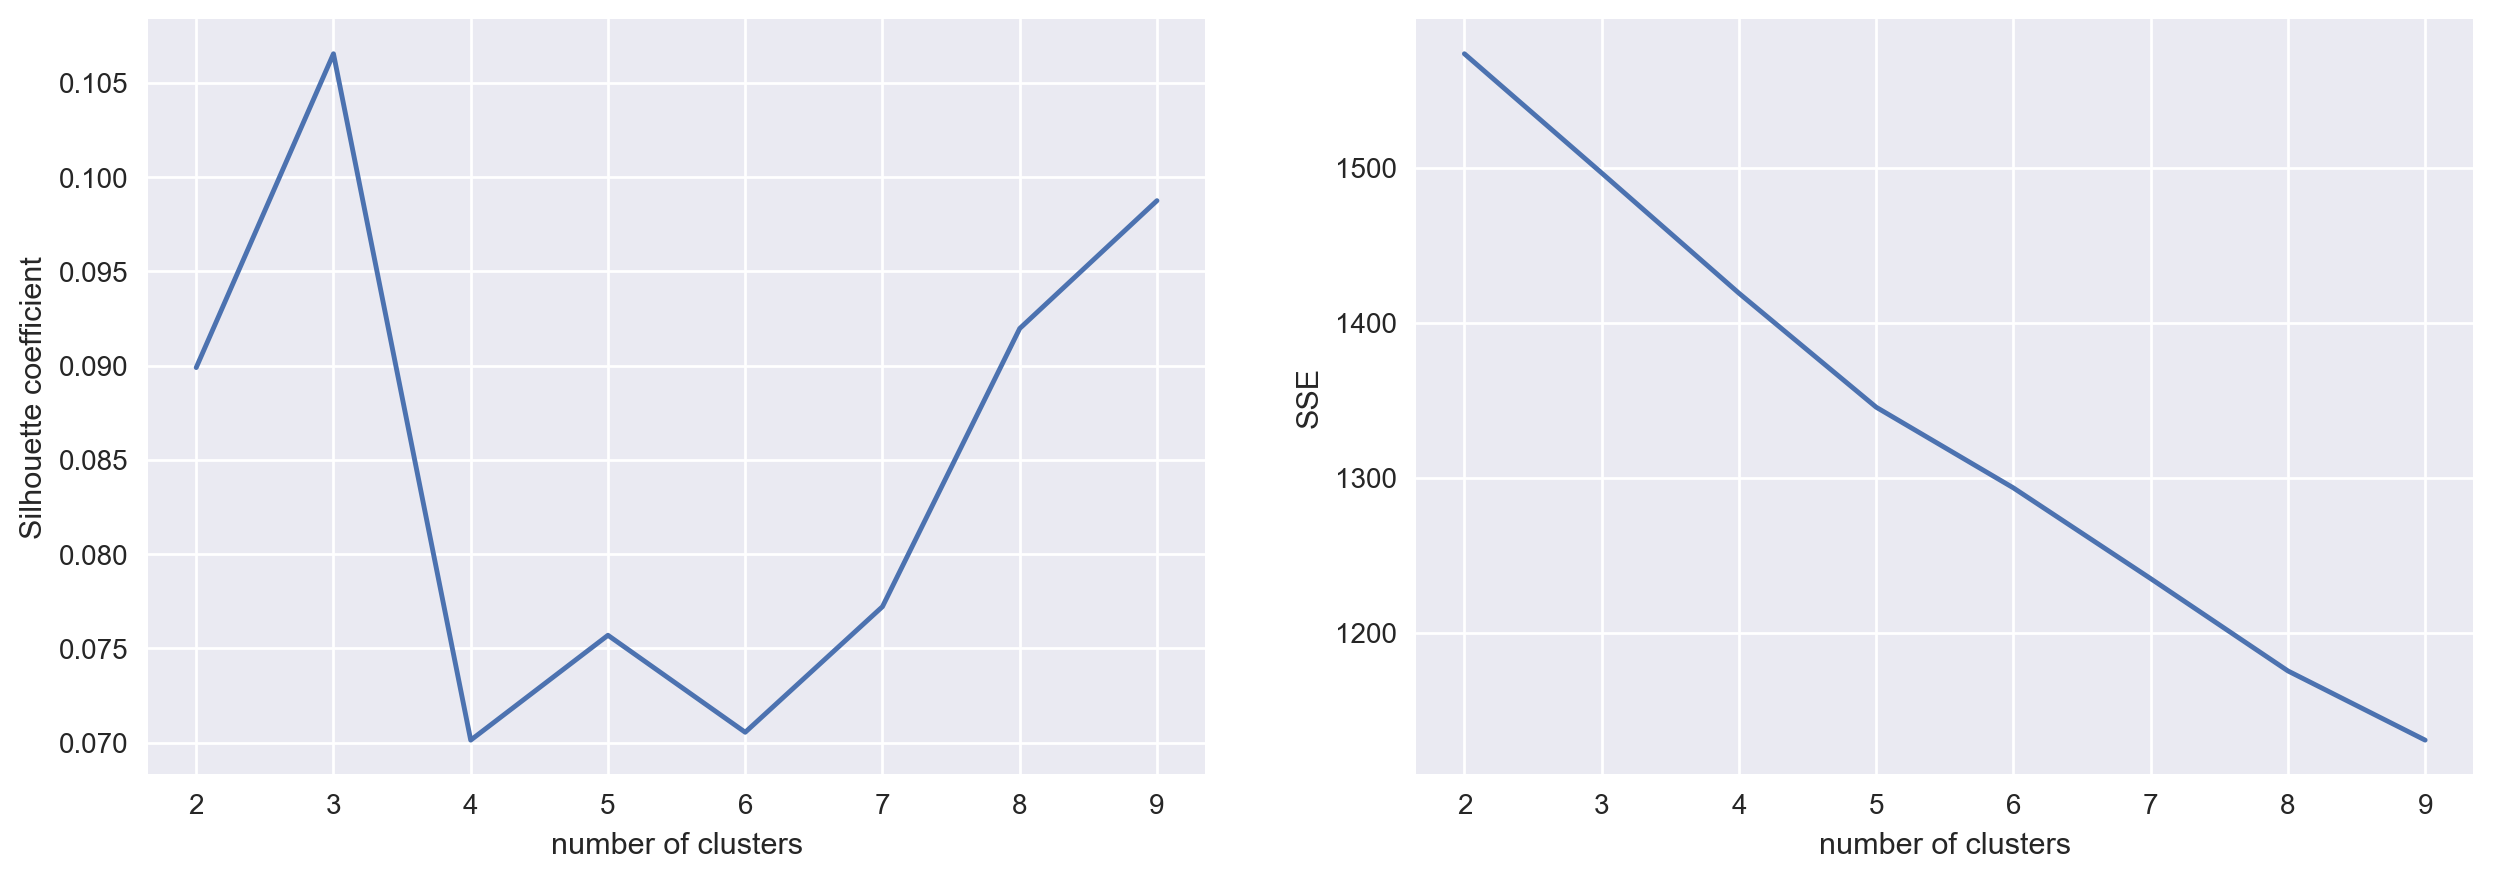

In [19]:
k_clusters = range (2, 10)
fig, ax = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)

ax[0].plot(k_clusters, Sil_coefs)
ax[0].set_xlabel('number of clusters')
ax[0].set_ylabel('Silhouette coefficient')

ax[1].plot(k_clusters, SSEs)
ax[1].set_xlabel('number of clusters')
ax[1].set_ylabel('SSE')


In [29]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path2 = '/Users/xzhou/github/project_files/yelp/yelp_km_scores.pkl'

try:    
    with open(pkl_path2, 'rb') as pkl_file:
        Sil_coefs = pickle.load(pkl_file)
        SSEs = pickle.load(pkl_file)
except:
    with open(pkl_path2, 'wb') as pkl_file:
        pickle.dump(Sil_coefs, pkl_file)
        pickle.dump(SSEs, pkl_file)

In [ ]:
DB Scan, Agglomerative Clustering